Map:   0%|          | 0/2871 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/134 [00:00<?, ? examples/s]

/tmp/ipython-input-2590982169.py:43: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
100,2.353700
200,2.167600
300,2.164200
400,2.178100
500,2.120200
600,2.131900
700,2.176700


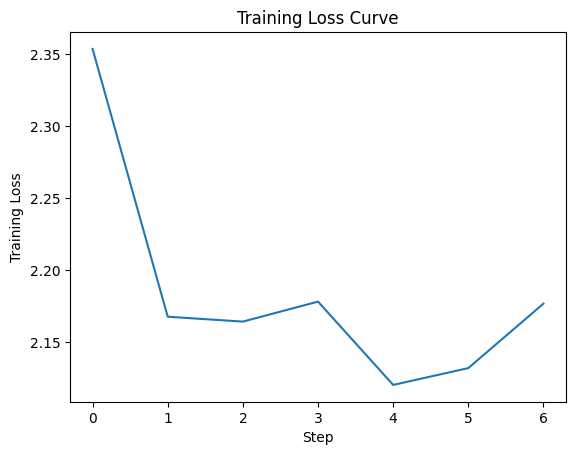

['This is an example article to test summarization by the fine tuned T5 model. The model should produce a summary capturing the main point of the article.']


In [10]:
!pip install -q transformers datasets evaluate accelerate sentencepiece
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate
model_name = "t5-small"
dataset = load_dataset("cnn_dailymail","3.0.0",split={"train":"train[:1%]","validation":"validation[:1%]"})
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
max_input_length = 512
max_target_length = 128
def preprocess(examples):
    inputs = ["summarize: " + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
tokenized = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
rouge = evaluate.load("rouge")
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    if isinstance(pred_ids, tuple):
        pred_ids = pred_ids[0]
    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    return {"rouge1": result["rouge1"].mid.fmeasure, "rouge2": result["rouge2"].mid.fmeasure, "rougeL": result["rougeL"].mid.fmeasure}
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/t5-small-summarization",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    eval_steps=200,
    logging_steps=100,
    save_steps=200,
    num_train_epochs=1,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=False
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)
trainer.train()
trainer.save_model("/content/t5-small-summarization-final")
examples = ["The quick brown fox jumps over the lazy dog. This is an example article to test summarization by the fine tuned T5 model. The model should produce a concise summary capturing the main point of the article."]
inputs = ["summarize: " + ex for ex in examples]
inputs_tok = tokenizer(inputs, return_tensors="pt", truncation=True, padding=True, max_length=max_input_length)
model = model.to("cuda")
inputs_tok = {k: v.to("cuda") for k, v in inputs_tok.items()}
generated = model.generate(**inputs_tok, max_length=60, num_beams=4)
import matplotlib.pyplot as plt
logs = trainer.state.log_history
loss_steps = [x["loss"] for x in logs if "loss" in x]
loss_x = list(range(len(loss_steps)))
plt.plot(loss_x, loss_steps)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.show()
print(tokenizer.batch_decode(generated, skip_special_tokens=True))
